В приложенном файле 3 датасета:

1) Данные треков - Richtracks (описание приложено)  
2) Данные точек этих треков - IncomingTrackPoints (описание также приложено)  
3) Наборы токен-платформа (iOS или Android) 

Задание:

1) Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?  
2) Переведите все параметры в одинаковую размерность  
3) В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.  

Срок выполнения - 1 неделя ( до 14.02)  

Формат решения - предпочтительно python - jupyter notebook, однако вы вольны выполнять решение на любом другом используемом языке, на оценку это не влияет.

Ссылка на данные: ***

In [159]:
import pandas as pd
import numpy as np
import os
import pickle
import datetime
import math
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, log_loss, accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from catboost import CatBoostClassifier, cv, Pool

import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

## Загрузим данные
Загрузка происходит с уже сдампленных pikle файлов т.к. парсинг даты-времени на файле inc_points занимает достаточно много времени. Единожды считанный и пропарсенный я сдампил и далее грузил в случае необходимости с него.

In [2]:
"""
inc_points = pd.read_csv("inc_points_2.csv", parse_dates = ['PointDate'])
rich_tracks = pd.read_csv("rich_tracks_2.csv", parse_dates = ['StartDate','EndDate'])
os = pd.read_csv("os.csv")
"""

'\ninc_points = pd.read_csv("inc_points_2.csv", parse_dates = [\'PointDate\'])\nrich_tracks = pd.read_csv("rich_tracks_2.csv", parse_dates = [\'StartDate\',\'EndDate\'])\nos = pd.read_csv("os.csv")\n'

In [4]:
"""
with open('inc_points.pickle', 'wb') as f:
    pickle.dump(inc_points, f)
with open('rich_tracks.pickle', 'wb') as f:
    pickle.dump(rich_tracks, f)
with open('os.pickle', 'wb') as f:
    pickle.dump(os, f)
"""

"\nwith open('inc_points.pickle', 'wb') as f:\n    pickle.dump(inc_points, f)\nwith open('rich_tracks.pickle', 'wb') as f:\n    pickle.dump(rich_tracks, f)\nwith open('os.pickle', 'wb') as f:\n    pickle.dump(os, f)\n"

In [5]:
with open('inc_points.pickle', 'rb') as f:
    inc_points = pickle.load(f)
with open('rich_tracks.pickle', 'rb') as f:
    rich_tracks = pickle.load(f)
with open('os.pickle', 'rb') as f:
    os = pickle.load(f)

## Посмотрим на данные rich_tracks

In [6]:
print(rich_tracks.shape)
print(rich_tracks.count())

(4000, 64)
Id                        4000
TrackToken                4000
DeviceToken               4000
IncomingTrackId           4000
StartDate                 4000
EndDate                   4000
Distance                  4000
Duration                  4000
AccelerationCount         4000
DecelerationCount         4000
Rating                    4000
PhoneUsage                4000
TrackOrigin               4000
OriginChanged             4000
AddressStart              3999
AddressFinish             3999
DistanceGPS               4000
Urban                     4000
Region                    2824
Country                   3999
RatingOverSpeed           4000
RatingAcceleration        4000
RatingTimeOfDay           4000
RatingPhoneUsage          4000
OverSpeedMileage          4000
MidOverSpeedMileage       4000
HighOverSpeedMileage      4000
OriginalTrackOrigin       2000
CompanyId                 4000
RushHours                 4000
                          ... 
KAcceleration             27

Часть данных полностью отсутствует, вероятно их удалили по каким либо причинам, выкинем их.

In [7]:
rich_tracks.drop(columns=['VehicleId', 'BeaconId','Prediction', 'Shared'], inplace= True)

In [8]:
rich_tracks.iloc[:,:20].describe()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,DistanceGPS
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,5.025274e+06,1.975498e+07,58.595608,26.312996,0.99775,1.609500,3.665005,1.176963,16.625775
std,2.219729e+05,1.465210e+06,378.721275,33.251872,2.51949,3.051039,1.208396,5.250283,30.632668
min,4.123769e+06,1.483781e+07,-0.937060,-0.333333,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4.962515e+06,1.876637e+07,3.087012,7.950000,0.00000,0.000000,2.750000,0.000000,3.140000
50%,5.145890e+06,2.066041e+07,7.648940,15.991667,0.00000,1.000000,4.000000,0.000000,7.350500
75%,5.147531e+06,2.068451e+07,18.760422,31.704167,1.00000,2.000000,4.800000,1.133333,16.578250
max,5.201839e+06,2.151483e+07,13469.899710,484.233333,64.00000,63.000000,5.000000,295.366667,547.887000


In [9]:
rich_tracks.iloc[:,20:40].describe()

,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,2992.000000,2792.000000,2992.000000,2792.000000,4000.000000,4000.000000,4000.000000
mean,3.690175,4.304075,4.401226,4.744588,3.448352,1.362796,1.063172,1640.588250,6.769062,2.167100,17.395867,3.972205,0.710976,0.950218,0.998997,0.896938,79.333980,43.557039,0.026779
std,1.745413,1.195178,1.075888,0.741834,8.436154,4.702051,5.681874,936.666098,19.260186,13.578005,24.923961,1.363921,0.323938,0.094414,0.031654,0.160901,26.562182,17.395035,0.192427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.648490,4.485274,0.000000
25%,2.500000,4.000000,4.000000,5.000000,0.166000,0.000000,0.000000,1061.000000,0.000000,0.000000,0.000000,3.750000,0.380000,0.915000,1.000000,0.875000,61.252854,31.636996,0.000000
50%,5.000000,5.000000,5.000000,5.000000,0.888000,0.089500,0.000000,1061.000000,0.000000,0.000000,9.250000,4.650000,0.890000,1.000000,1.000000,0.980000,75.452286,40.960496,0.000000
75%,5.000000,5.000000,5.000000,5.000000,3.051250,0.776250,0.282250,3129.000000,4.750000,0.000000,22.487500,5.000000,1.000000,1.000000,1.000000,1.000000,93.969118,52.773732,0.000000
max,5.000000,5.000000,5.000000,5.000000,120.906000,76.184000,170.944000,3129.000000,477.816681,354.533325,280.983337,5.000000,1.000000,1.000000,1.000000,1.000000,503.073334,124.975036,5.933333


In [10]:
rich_tracks.iloc[:,40:60].describe()

,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,DeviationRatio,DeviationMeters
count,4000.000000,4000.00000,2992.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,1208.000000,2945.000000,2945.000000
mean,0.721054,0.03993,0.998997,65.350000,94.781250,99.925000,53.706250,65.057191,0.105500,0.324000,59.480250,100.290000,115.711000,145.863750,4.701987,0.000030,16.827088
std,2.084145,0.30080,0.031654,47.591425,18.896366,2.737928,38.225126,34.532222,0.495915,6.192585,174.341004,275.960801,418.169436,362.921322,1.017948,0.000638,23.363352
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.126820
25%,0.000000,0.00000,1.000000,0.000000,100.000000,100.000000,25.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,5.694779
50%,0.000000,0.00000,1.000000,100.000000,100.000000,100.000000,50.000000,77.500008,0.000000,0.000000,8.000000,17.000000,15.000000,34.000000,5.000000,0.000000,8.959902
75%,0.582250,0.00000,1.000000,100.000000,100.000000,100.000000,100.000000,95.312508,0.000000,0.000000,45.000000,82.000000,96.000000,137.000000,5.000000,0.000000,17.999333
max,64.157000,9.18900,1.000000,100.000000,100.000000,100.000000,100.000000,100.000008,11.000000,307.000000,2931.000000,6331.000000,17713.000000,7548.000000,5.000000,0.021277,331.586933


In [11]:
rich_tracks.iloc[:,[12,13,27]].describe()

,TrackOrigin,OriginChanged,OriginalTrackOrigin
count,4000,4000,2000
unique,3,2,2
top,OriginalDriver,True,OriginalDriver
freq,2000,2000,1999


In [12]:
rich_tracks.iloc[:,[12,13]].dropna().describe()

,TrackOrigin,OriginChanged
count,4000,4000
unique,3,2
top,OriginalDriver,True
freq,2000,2000


In [13]:
rich_tracks.iloc[:,[12,13,27]].dropna().describe()

,TrackOrigin,OriginChanged,OriginalTrackOrigin
count,2000,2000,2000
unique,2,1,2
top,Passanger,True,OriginalDriver
freq,1678,2000,1999


In [14]:
rich_tracks[rich_tracks['OriginalTrackOrigin'] != 'OriginalDriver'][['TrackOrigin','OriginalTrackOrigin']].dropna()

,TrackOrigin,OriginalTrackOrigin
3103,Taxi,Walking


Итого мы имеем в данной таблице 4000 треков, у всех проставлен TrackOrigin, у 2000 он указан как OriginalDriver,
у 1678 как Passanger, у 322 как Taxi. У всех TrackOrigin = OriginalDriver OriginChanged = False и не проставлен OriginalTrackOrigin. У оставшихся поездок где TrackOrigin указан как Passanger или Taxi, OriginChanged = True OriginalTrackOrigin = OriginalDriver, только у одной OriginalDriver = Walking.  
Я ничего не могу утверждать исходя из этой информации, но возможно, если данные целиком "синтетические", это приведет к проблемам при выполнении 3го задания.

## Посмотрим на данные inc_points

In [15]:
print(inc_points.shape)
inc_points.head(5)

(3791240, 12)


,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23+03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23+03:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34+03:00,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34+03:00,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34+03:00,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [16]:
inc_points.IncomingTrackId.nunique()

2587

In [17]:
inc_points.describe()

,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
count,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06,3.791240e+06
mean,2.069974e+07,2.787974e+01,3.238493e+01,7.000047e+01,1.262621e+05,5.893222e-02,1.140180e-01,1.571310e+09,9.741584e-02,3.268433e-01,3.249853e-01
std,2.306869e+05,3.236938e+01,3.570846e+01,4.533145e+01,1.566129e+05,7.250596e-01,1.112617e+00,1.511823e+05,1.759071e+00,2.727367e+00,2.906690e+00
min,1.988839e+07,0.000000e+00,-4.315735e+01,-1.563825e+02,-4.500000e+05,-2.189765e+01,-3.603381e+01,1.570343e+09,-4.738030e+01,-4.837484e+01,-3.865796e+01
25%,2.066336e+07,7.917608e-02,1.358303e+00,3.762630e+01,3.414900e+04,0.000000e+00,0.000000e+00,1.571303e+09,-2.143555e-01,-6.968536e-01,-8.502808e-01
50%,2.068318e+07,1.290722e+01,5.275425e+01,4.923103e+01,1.102930e+05,0.000000e+00,0.000000e+00,1.571310e+09,0.000000e+00,-7.299805e-02,-3.132019e-01
75%,2.072174e+07,5.079600e+01,5.576917e+01,1.038563e+02,1.642000e+05,0.000000e+00,0.000000e+00,1.571317e+09,1.975403e-01,3.972015e-01,2.856140e-01
max,2.151483e+07,2.251463e+02,6.949774e+01,1.586358e+02,3.087814e+06,2.549077e+01,3.598226e+01,1.571850e+09,4.149518e+01,3.452544e+01,4.120547e+01


In [18]:
inc_points.shape == inc_points.dropna().shape

True

In [19]:
inc_points.shape == inc_points.drop_duplicates().shape

False

In [20]:
inc_points.shape[0] - inc_points.drop_duplicates().shape[0]

487

Данные без пропусков, зато имеются полные дубли в небольшом количестве.
Так же видим что на однин набор значений с GPS имеется по несколько значений с акселерометра

## Посмотрим на данные os

In [21]:
print (os.shape)
print (os.nunique())
print (os.drop_duplicates().shape == os.shape)
os.head(1)

(4416, 2)
DeviceToken    4395
os_version        2
dtype: int64
True


,DeviceToken,os_version
0,2A768BE9-24E4-4274-AE30-03D07EE1D5B8,Android


На 4416 записей имеем 4395 уникальных DeviceToken, при этом полных дублей нету, а значит что у 21й записи DeviceToken проставлены обе версии os_version. Установить правильную пока что невозможно, попробуем сделать это позже узнав разницу между данными android и ios.  
Пока просто удалим дубли оставив первые вхождения при переносе os_version.

# Задание:

# 1) Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?  

## Добавим os_version в датасет rich_tracks

In [22]:
rich_tracks_os = pd.merge(rich_tracks, os.drop_duplicates(subset=['DeviceToken']), how = "left", on = "DeviceToken")

In [23]:
rich_tracks_os.head(2)

,Id,TrackToken,DeviceToken,IncomingTrackId,StartDate,EndDate,Distance,Duration,AccelerationCount,DecelerationCount,...,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,DeviationRatio,DeviationMeters,os_version
0,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,...,1.0,1.0,111.0,6.0,120.0,7.0,NaN,0.0,7.390443,iOS
1,5148032,4BDD2EE6-FF53-4762-83DA-35A849935A99,669AFC5F-921C-40B9-B090-587BC95D34C2,20691750,2019-10-17 17:35:30.0000000 +05:00,2019-10-17 18:00:56.0000000 +05:00,414.076500,25.433333,0,1,...,0.0,0.0,16.0,0.0,29.0,0.0,NaN,0.0,17.956039,Android


## Добавим os_version и TrackOrigin в датасет inc_points

In [24]:
inc_points_os = pd.merge(inc_points, rich_tracks_os.iloc[:,[3,12,60]], how = "left", on = "IncomingTrackId")

In [25]:
print(inc_points.shape)
print(inc_points_os.shape)

(3791240, 12)
(3791240, 14)


In [26]:
inc_points_os.head(1)

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal,TrackOrigin,os_version
0,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23+03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434,OriginalDriver,iOS


## Сравним данные для разных ОС

In [27]:
inc_points_os[inc_points_os['os_version'] == 'Android'].describe()

,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
count,8.222900e+05,822290.000000,822290.000000,822290.000000,8.222900e+05,822290.000000,822290.000000,8.222900e+05,822290.000000,822290.000000,822290.000000
mean,2.068194e+07,32.280508,36.047651,62.741392,1.629858e+05,0.271712,0.525690,1.571327e+09,0.538355,2.186820,2.769375
std,3.021033e+05,32.885406,35.380082,46.505349,2.120040e+05,1.538189,2.343314,1.931554e+05,3.657746,5.347619,5.485947
min,1.989194e+07,0.000000,-38.206772,-90.543041,-2.800000e+05,-21.897650,-36.033807,1.570801e+09,-47.380302,-48.374844,-38.657963
25%,2.065884e+07,1.352813,45.862139,37.547704,7.100000e+04,-0.014091,-0.044735,1.571311e+09,-0.675186,-0.050280,0.000000
50%,2.067715e+07,22.186904,55.384326,39.167743,1.506130e+05,0.002498,0.031793,1.571323e+09,0.000000,1.170765,1.989563
75%,2.073705e+07,57.149260,55.854777,76.924859,1.910000e+05,0.160400,0.955636,1.571353e+09,1.331176,6.996506,7.941810
max,2.151483e+07,225.146297,69.497742,153.562202,2.641100e+06,25.490773,35.982261,1.571850e+09,41.495178,34.525444,41.205471


In [28]:
inc_points_os[inc_points_os['os_version'] == 'iOS'].describe()

,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
count,2.968950e+06,2.968950e+06,2.968950e+06,2.968950e+06,2.968950e+06,2968950.0,2968950.0,2.968950e+06,2.968950e+06,2.968950e+06,2.968950e+06
mean,2.070466e+07,2.666089e+01,3.137050e+01,7.201097e+01,1.160910e+05,0.0,0.0,1.571305e+09,-2.470809e-02,-1.883020e-01,-3.520207e-01
std,2.063155e+05,3.211855e+01,3.573255e+01,4.479337e+01,1.356303e+05,0.0,0.0,1.369441e+05,4.207902e-01,5.957172e-01,5.833415e-01
min,1.988839e+07,0.000000e+00,-4.315735e+01,-1.563825e+02,-4.500000e+05,0.0,0.0,1.570343e+09,-6.521149e+00,-4.982590e+00,-6.352142e+00
25%,2.066516e+07,0.000000e+00,1.344217e+00,3.766937e+01,2.746800e+04,0.0,0.0,1.571302e+09,-1.773987e-01,-7.210541e-01,-8.676300e-01
50%,2.068523e+07,1.022400e+01,5.181080e+01,5.406870e+01,1.028110e+05,0.0,0.0,1.571308e+09,-8.941650e-03,-1.878967e-01,-4.721832e-01
75%,2.071867e+07,4.879086e+01,5.574548e+01,1.038765e+02,1.552580e+05,0.0,0.0,1.571314e+09,1.340637e-01,1.331787e-01,-4.821777e-03
max,2.149924e+07,2.235964e+02,6.936569e+01,1.586358e+02,3.087814e+06,0.0,0.0,1.571813e+09,4.982407e+00,7.627045e+00,8.325272e+00


В целом уже видна разница в распределениях данных с акселерометров, а так же в данных с iOS не посчитаны колонки Acceleration и Deceleration.  
Проведем визуальный анализ распределения признаков попарно для Android и iOS.

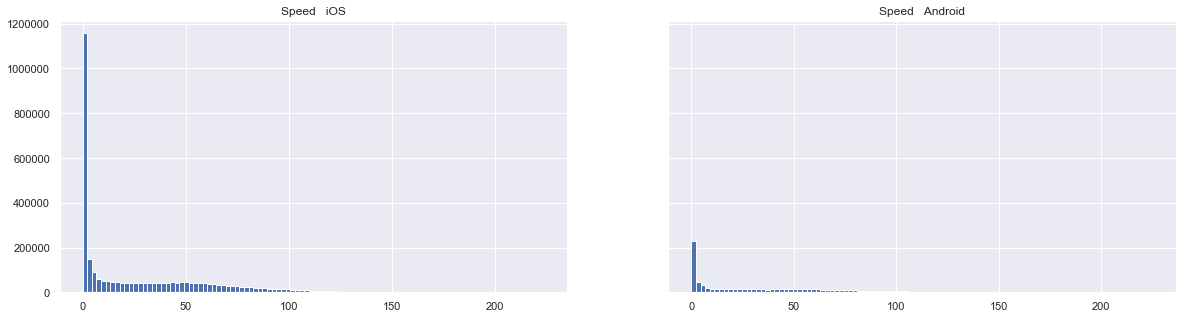

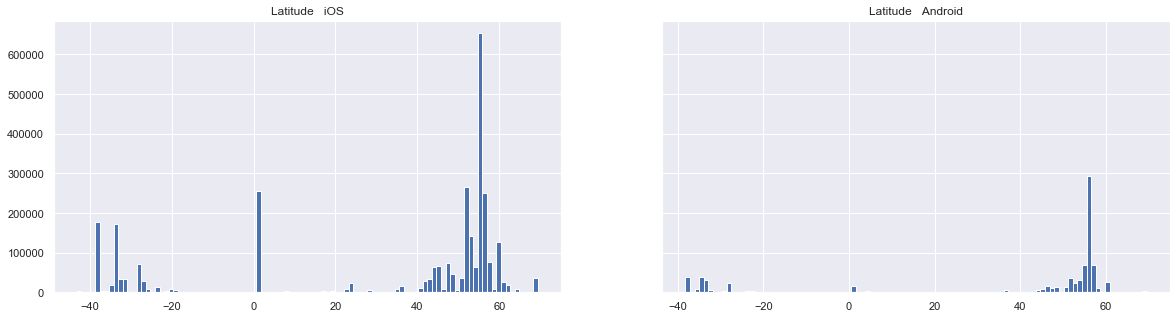

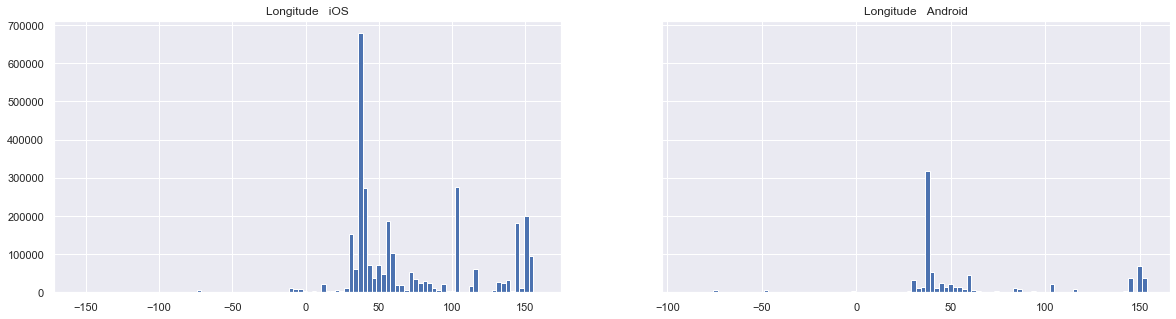

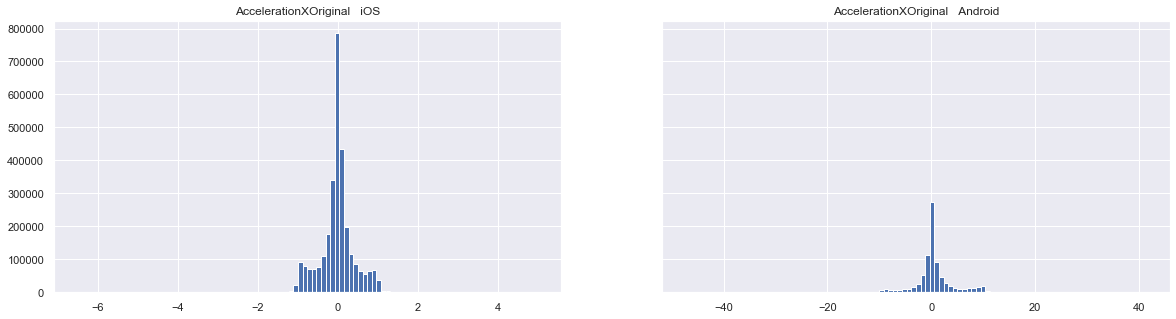

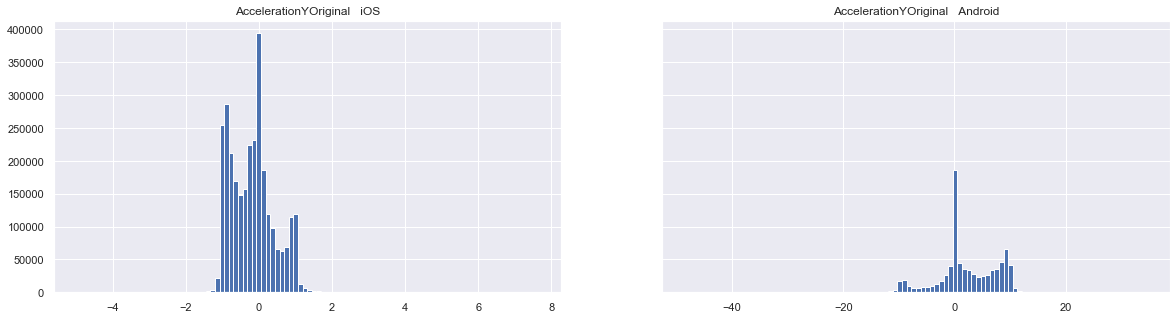

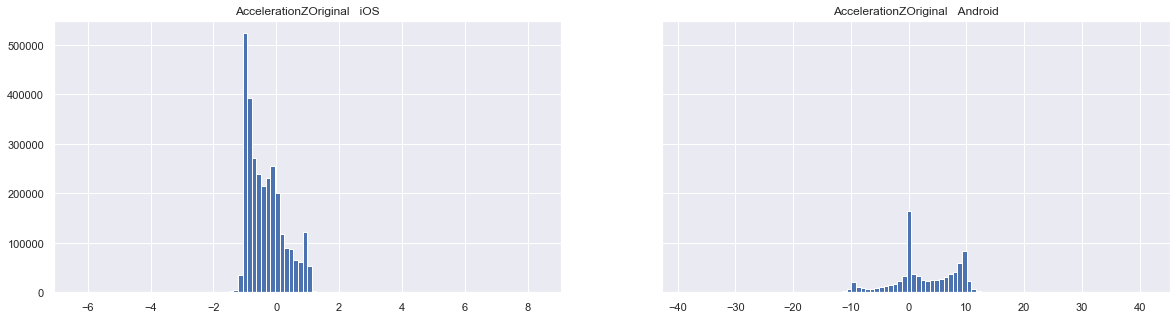

In [29]:
x = [1,2,3,9,10,11]
for i in x:
    f, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    inc_points_os[inc_points_os['os_version'] == 'iOS'].iloc[:,i].hist(bins=100, ax=ax[0]);
    ax[0].set_title(str(inc_points_os.columns[i]) + "   iOS")
    inc_points_os[inc_points_os['os_version'] == 'Android'].iloc[:,i].hist(bins=100, ax=ax[1]);
    ax[1].set_title(str(inc_points_os.columns[i]) + "   Android")

# Задание:

# 1) Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?  

# Ответ:  Это параметры  AccelerationXOriginal,	AccelerationYOriginal, AccelerationZOriginal

# 2) Переведите все параметры в одинаковую размерность  
Небольшое гугление показало что iOS меряет ускорение в силах тяжети (gfrorce), а Андроид в м/с**2, для перевода одного в другое нужно умножить/поделить на ~9.81, переведем все в силы тяжетси

In [30]:
inc_points_os.loc[inc_points_os['os_version'] == 'Android', 'AccelerationXOriginal'] =\
inc_points_os[inc_points_os['os_version']=='Android']['AccelerationXOriginal'].apply(lambda x: x/9.81);

inc_points_os.loc[inc_points_os['os_version'] == 'Android', 'AccelerationYOriginal'] =\
inc_points_os[inc_points_os['os_version']=='Android']['AccelerationYOriginal'].apply(lambda x: x/9.81);

inc_points_os.loc[inc_points_os['os_version'] == 'Android', 'AccelerationZOriginal'] =\
inc_points_os[inc_points_os['os_version']=='Android']['AccelerationZOriginal'].apply(lambda x: x/9.81);

И взглянем еще раз на распределение

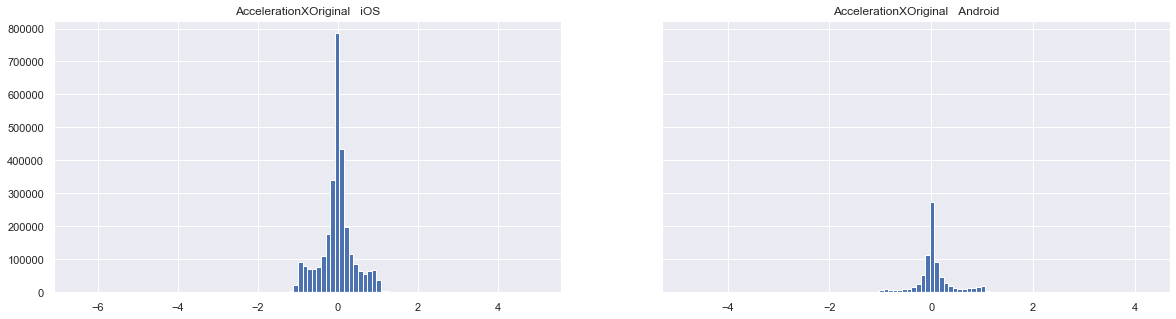

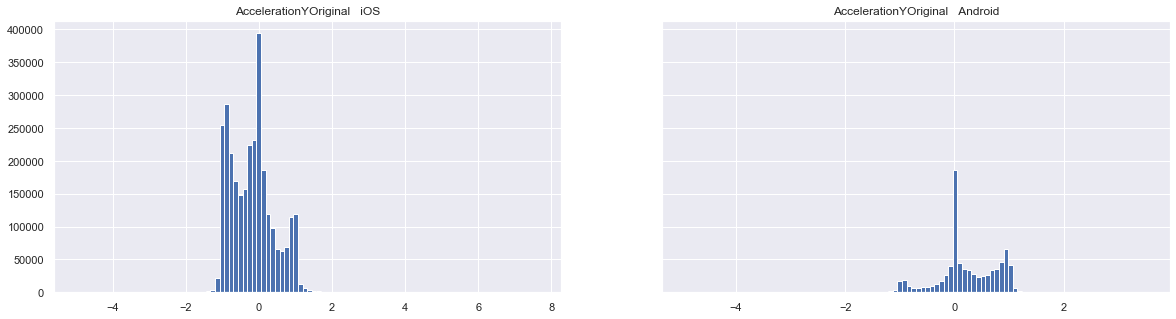

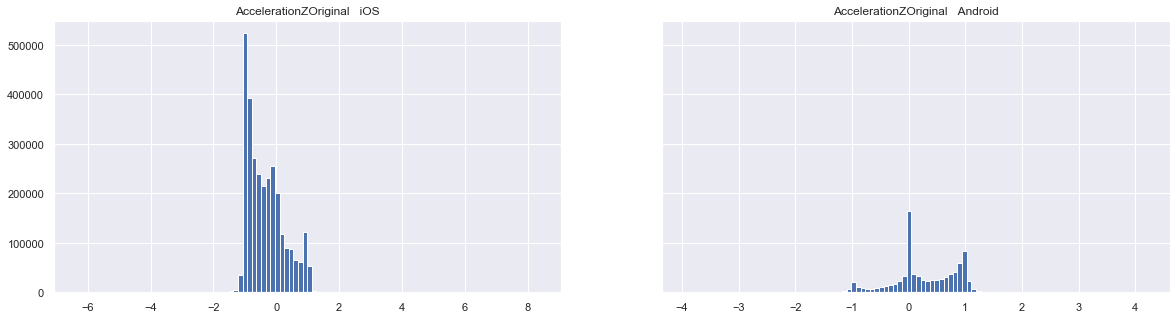

In [31]:
x = [9,10,11]
for i in x:
    f, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    inc_points_os[inc_points_os['os_version'] == 'iOS'].iloc[:,i].hist(bins=100, ax=ax[0]);
    ax[0].set_title(str(inc_points_os.columns[i]) + "   iOS")
    inc_points_os[inc_points_os['os_version'] == 'Android'].iloc[:,i].hist(bins=100, ax=ax[1]);
    ax[1].set_title(str(inc_points_os.columns[i]) + "   Android")

## Теперь данные акселерометров в одной размерности, но тем не менее все равно видна разница в показаниях между андроид и ios по оси z, вероятно в состоянии покоя iOS выдает значение -1, а Android 0. Так же данные по оси Y выглядят "отзеркаленными". Так как я не имею данных о том, был ли телефон(или другое устройство) каким либо образом строго оринтирован и закреплен в автомобиле то с данными акселерометра я более ничего делать на данном этапе не буду.

# 3) В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.

## Начнем с простого подхода, попробуем сделать предсказание из того что есть.
Для начала немного преобразуем данные для обучения модели

### Сделаем лейбл энеодинг на версию ос

In [32]:
encoder_os = LabelEncoder()
inc_points_os['os_version'] = encoder_os.fit_transform(inc_points_os.os_version)

print(encoder_os.classes_)

['Android' 'iOS']


### Считаем пассажирскими поездками в том числе поездки с track origin "Taxi"

In [33]:
encoder_track_one_hot = OneHotEncoder()
track_origin = encoder_track_one_hot.fit_transform(inc_points_os['TrackOrigin'].values.reshape(-1, 1))

In [34]:
inc_points_os['TrackOrigin_Passanger'] = track_origin.todense()[:,1] + track_origin.todense()[:,2]

In [35]:
inc_points_os.drop(columns='TrackOrigin', inplace=True)

### Переведем PointDate из datetime в time epoch

In [36]:
inc_points_os['PointDate_epoch'] = inc_points_os['PointDate'].apply(lambda x: x.timestamp())

### Посмотрим на корреляцию между признаками "как есть", может у нас есть какой то "убер" признак который однозначно скажет была ли поездка пассажирской

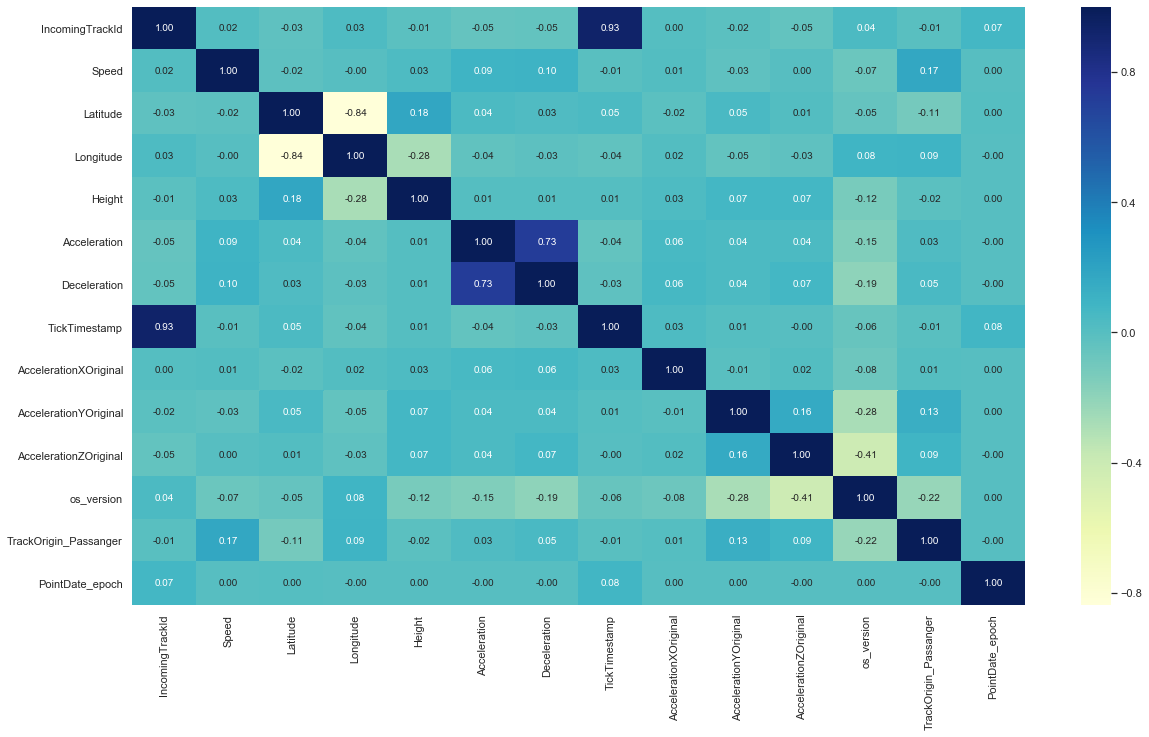

In [37]:
corr = inc_points_os.corr()

plt.figure(figsize = (20, 11)) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

Да, такой "чудо признак" имеется, так как данные у нас своего рода сортированные по track origin то в них можно проктически точно понять была ли поездка пассажирской по ticktimestamp, но использовать эти данные для обучения будет не корректно, так как в реальных данных этот параметр не будет зависеть от track origin.

### Попробуем "втупую" обучить xgboost на этих данных и посмотреть на feature importance

In [38]:
#model_xgb = XGBClassifier(random_state=42, n_jobs=-1)
#model_xgb.fit(inc_points_os.drop(columns=['TrackOrigin_Passanger','PointDate']), inc_points_os.TrackOrigin_Passanger)

In [116]:
def plot_features(booster, figsize, cols): 
    str_cols = [str(x) for x in cols]
    booster.get_booster().feature_names = list(str_cols)
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, max_num_features=50)

def plot_features_catboost(booster): 
    fea_imp = pd.DataFrame({'imp': booster.feature_importances_, 'col': booster.feature_names_})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
    plt.title('CatBoost - Feature Importance')
    plt.ylabel('Features')
    plt.xlabel('Importance');

In [40]:
#plot_features(model_xgb, (14,15), inc_points_os.drop(columns=['TrackOrigin_Passanger','PointDate']).columns);

Как и предполагалось модель по максимуму использует "дыру" в данных, для обучения не подойдут такие параметры как:  
TickTimestamp, IncomingTrackId.
А так же придется убрать из обучения такие данные как Longitude и Latitude (и возможно Height) так как они просто деанонимизурют сами поездки не готовя модель к новым данным из других областей.

## Попробуем произвести предсказание целевой характеристики используя "статистический подход" к данным треков, применим аггрегирующие функции к данным и получим 4 признака из каждого - среднее, минимум, максимум и разницу между максимумом и минимумом каждого признака по каждому треку, и выкинем те из них что дублируют и практически дублируют друг друга.

In [41]:
#inc_points_os = inc_points_os.drop(columns=['Acceleration','Deceleration'])

In [42]:
#ctd - columns_to_drop
ctd = ['os_version', 'TrackOrigin_Passanger', 'PointDate', 'TickTimestamp', 'PointDate_epoch']
ctd1 = ['Speed']
ctd2 = ['Latitude', 'Longitude', 'Height']

inc_points_os_mean = inc_points_os.groupby('IncomingTrackId', as_index=False).mean()
inc_points_os_max = inc_points_os.groupby('IncomingTrackId', as_index=False).max().drop(columns=ctd)
inc_points_os_min = inc_points_os.groupby('IncomingTrackId', as_index=False).min().drop(columns=ctd)

inc_points_os_min_0 = inc_points_os_min.copy()
inc_points_os_min_0['IncomingTrackId'] = 0
inc_points_os_diff = inc_points_os_max - inc_points_os_min_0

inc_points_os_min = inc_points_os_min.drop(columns=ctd1).drop(columns=ctd2)
inc_points_os_max = inc_points_os_max.drop(columns=ctd2)
inc_points_os_diff = inc_points_os_diff.drop(columns=ctd1)

In [43]:
inc_points_stats = inc_points_os_mean.\
merge(inc_points_os_max, on = 'IncomingTrackId', how = 'left', suffixes=('','_max')).\
merge(inc_points_os_min, on = 'IncomingTrackId', how = 'left', suffixes=('','_min')).\
merge(inc_points_os_diff, on = 'IncomingTrackId', how = 'left', suffixes=('','_diff'))

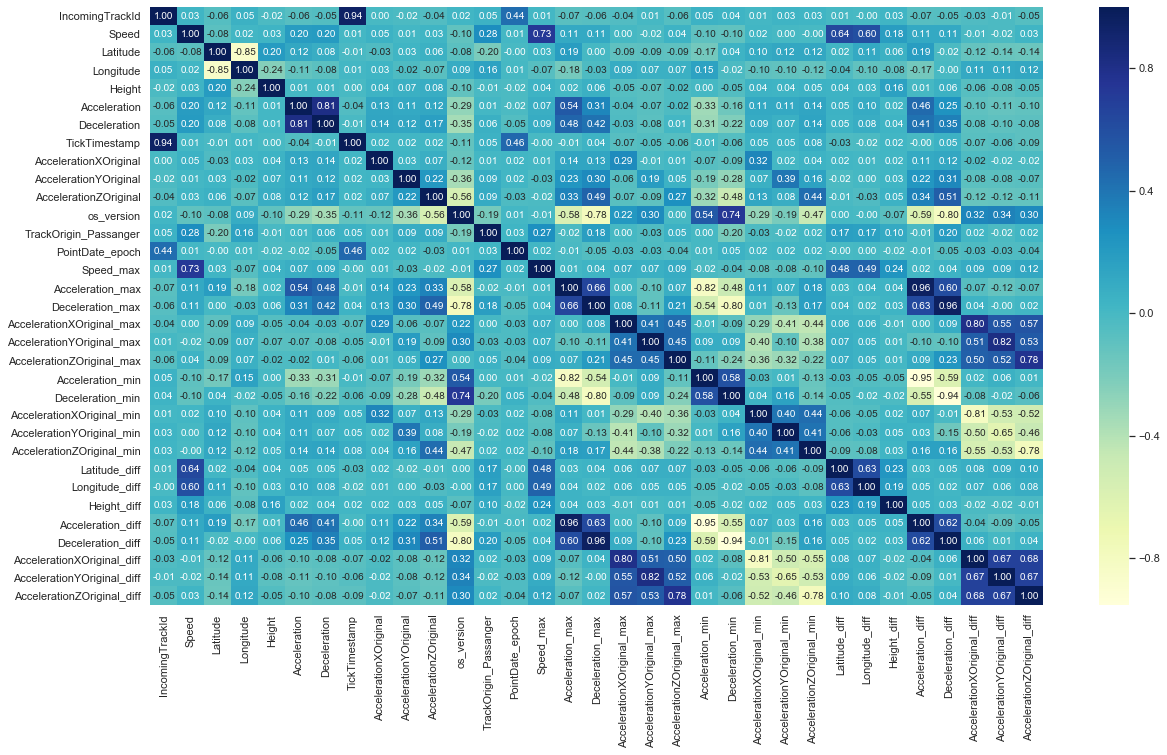

In [44]:
corr = inc_points_stats.corr()
plt.figure(figsize = (20, 11)) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

## Попробуем настроить валидацию на этот подход, сделаем отложенную выборку с перемешиванием данных.

In [45]:
X = inc_points_stats.drop(columns=[
                                   'TrackOrigin_Passanger', #целевая метрика
                                    'PointDate_epoch', #лик
                                    'TickTimestamp', #лик
                                   'IncomingTrackId', #лик
                                   'Latitude', #лик
                                   'Longitude', #лик
                                   'Height', #лик
                                   'os_version', #поидее недоступно в inc_points
                                  ])
y = inc_points_stats.TrackOrigin_Passanger

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle = True, train_size = 0.8, random_state = 42)

В качестве "точки отсчета" посмотрим на метрики получаемые при предсказании всех поездок как пассажирские или не пассажирские

In [46]:
y_pred_0 = np.zeros(y.shape[0])
print(classification_report(y,y_pred_0))

y_pred_1 = np.ones(y.shape[0])
print(classification_report(y,y_pred_1))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      2000
         1.0       0.00      0.00      0.00       587

    accuracy                           0.77      2587
   macro avg       0.39      0.50      0.44      2587
weighted avg       0.60      0.77      0.67      2587

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.23      1.00      0.37       587

    accuracy                           0.23      2587
   macro avg       0.11      0.50      0.18      2587
weighted avg       0.05      0.23      0.08      2587



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Обучим стандартный XGBoost на том что есть.

In [47]:
model_xgb = XGBClassifier(random_state=42, n_jobs=-1,)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_valid)
y_pred_proba = model_xgb.predict_proba(X_valid)

print(classification_report(y_valid,y_pred))
print('F1 score:', f1_score(y_valid,y_pred))
y_pred_proba = model_xgb.predict_proba(X_valid)
print('ROC-AUC score', roc_auc_score(y_valid, y_pred_proba[:,1]))
print(confusion_matrix(y_valid,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       394
         1.0       0.60      0.28      0.38       124

    accuracy                           0.78       518
   macro avg       0.70      0.61      0.63       518
weighted avg       0.76      0.78      0.75       518

F1 score: 0.3846153846153847
ROC-AUC score 0.7715531357458654
[[371  23]
 [ 89  35]]


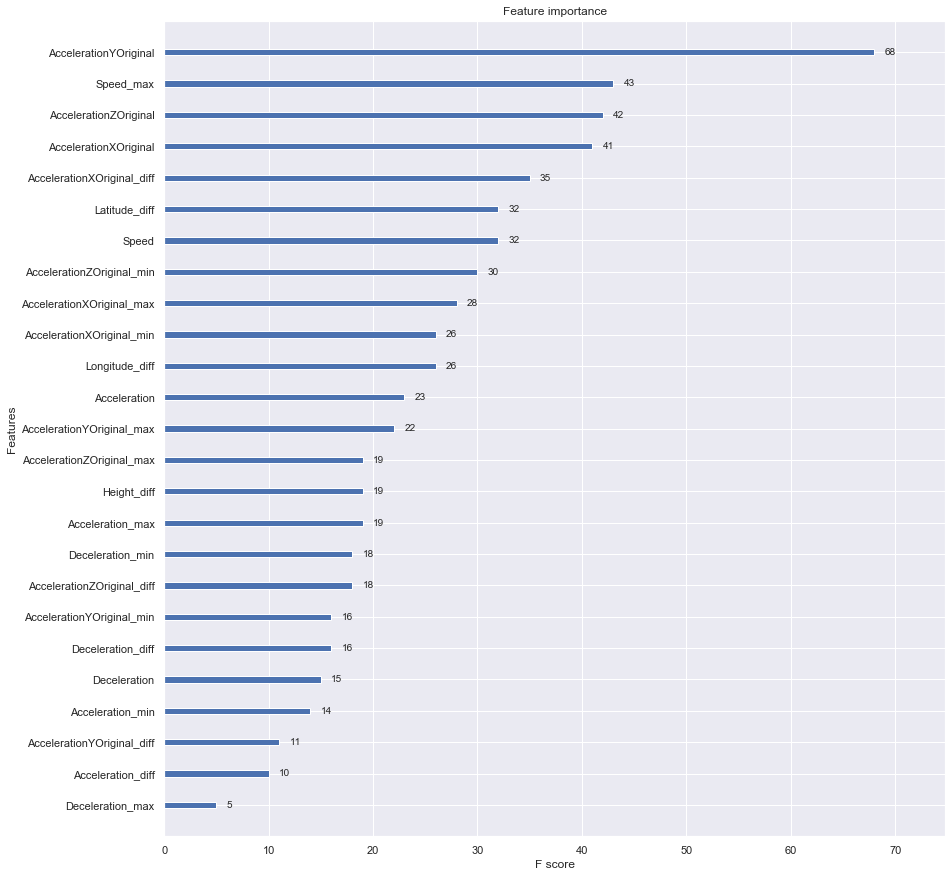

In [48]:
model_xgb.fit(X, y)
plot_features(model_xgb, (14,15), X.columns);

## Результат конечно лучше чем классификация всех поездок как 1 или 0, но не впечатляет, перейдем к нормальному созданию фичей из данных.

In [205]:
def euclidian_distance(p1, p2):
      return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# Haversine formula
def get_meters_from_lon_lat(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6370 # Средний радиус Земли
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d*1000

def get_meters_from_lat(lat):
    R = 6370
    dlat = math.radians(lat)
    a = math.sin(dlat/2) * math.sin(dlat/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d*1000

def get_meters_from_lon(lon):
    R = 6370
    dlon = math.radians(lon)
    a = math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d*1000

In [227]:
# Создание фичей из данных GPS
def build_features_for_track_gps(data):
    time = data[:,2]
    ride = data[:,[0,1]]
    
    #Получим перемещения в метрах из данных gps
    distances = []
    for i in range(1,len(ride)):
        distances.append(get_meters_from_lon_lat(ride[i-1], ride[i]))
    distances = np.array(distances)
    #Времена
    times = (np.hstack((time, [0])) - np.hstack(([0], time)))[1:-1]
    #Длина поездки, время и средняя скорость
    ride_length = sum(distances)
    ride_time = (max(time) - min(time))
    ride_speed = ride_length / ride_time
    start_stop_distance = get_meters_from_lon_lat(ride[0], ride[-1])
       
    features = [
        ride_length,
        ride_time,
        ride_speed,
        euclidian_distance(ride[0], ride[-1]), #Расстояние между начальной и конечной точкой маршрута, как будто у нас x y
        start_stop_distance #Расстояние между начальной и конечной точкой маршрута
    ]

    move_vectors = (np.vstack((ride, [0,0])) - np.vstack(([0,0], ride)))[1:-1]
    move_vectors_meters = []
    for i in range(len(move_vectors)):
        lat_vec = get_meters_from_lat(move_vectors[i][0])
        lon_vec = get_meters_from_lon(move_vectors[i][1])
        move_vectors_meters.append([lat_vec, lon_vec])
    move_vectors_meters = np.array(move_vectors_meters)
    m1 = move_vectors_meters[1:]
    m2 = move_vectors_meters[:-1]
    distances1 = np.linalg.norm(m1, axis=1)
    distances2 = np.linalg.norm(m2, axis=1)
    dot_product = (m1 * m2).sum(1) #Скалярное произведение
    denominator = np.maximum(distances1 * distances2, 0.01)
    angles = np.arccos(np.maximum(np.minimum(dot_product / denominator, 1.0), -1.0))
    angles = angles * 180 / math.pi

    g_forces = angles * (distances1 + distances2)
    features.extend(np.percentile(angles, [25, 50, 75, 90, 95, 99]))
  
    hists = [
        np.histogram(distances, bins=range(0, 45, 5))[0] / (len(distances) + 1.0),
        np.histogram(g_forces, bins=range(0, 2000, 100))[0]
    ]
    features.extend(list(itertools.chain(*hists)))

    return np.array(features)

In [228]:
# Создание фичей из данных акселерометров
def build_features_for_track_accel(data):
    ticks = data[:,0]
    acc_x = data[:,1]
    acc_y = data[:,2]
    acc_z = data[:,3]
    
    tick_time = max(ticks)-min(ticks)
    
    features = [
        tick_time,
        max(acc_x),
        max(acc_y),
        max(acc_z),
        min(acc_x),
        min(acc_y),
        min(acc_z),        
        np.mean(acc_x),
        np.mean(acc_y),
        np.mean(acc_z),
        max(acc_x)-min(acc_x),
        max(acc_y)-min(acc_y),
        max(acc_z)-min(acc_z)
        ]
    
    hists = [
        np.histogram(acc_x, bins=np.arange(-6.75,5.25,0.25))[0],
        np.histogram(acc_y, bins=np.arange(-5,8,0.25))[0],
        np.histogram(acc_z, bins=np.arange(-6.5,8.75,0.25))[0]
        ]
    
    features.extend(list(itertools.chain(*hists)))
    
    return np.array(features)

In [229]:
# Создание фичей
def build_features(inc_points):
    inc_points['PointDate_datetime'] = inc_points['PointDate'].copy()
    inc_points['PointDate'] = inc_points['PointDate'].apply(lambda x: x.timestamp())
    
    points_max = inc_points.groupby('IncomingTrackId', as_index=False).max()
    points_min = inc_points.groupby('IncomingTrackId', as_index=False).min()
    
    track_list = points_max['IncomingTrackId'].values
    features = []
    features_gps = []
    features_accel = []
    started_flag = 0
    for track_id in track_list:
        track_gps = inc_points[inc_points['IncomingTrackId'] == track_id].iloc[:,[2,3,4]].drop_duplicates().values
        feats_gps_track = build_features_for_track_gps(track_gps)
        
        track_accel = inc_points[inc_points['IncomingTrackId'] == track_id].iloc[:,[8,9,10,11]].drop_duplicates().values
        feats_accel_track = build_features_for_track_accel(track_accel)
        
        if started_flag == 0:
            features_gps = feats_gps_track
            features_accel = feats_accel_track
            started_flag +=1
        else:
            features_gps = np.vstack((features_gps, feats_gps_track))
            features_accel = np.vstack((features_accel, feats_accel_track))

        
    features = np.hstack((np.hstack((track_list.reshape(-1,1), features_gps)), features_accel))
    feature_cols = ['IncomingTrackId']
    feature_cols += ['ride_length','ride time', 'ride_speed','euclidian_dist','start_stop_dist']
    feature_cols += ['angle_25', 'angle_50','angle_75','angle_90','angle_95','angle_99']
    for i in range(0,8):
        feature_cols += ['dist_bin_' + str(i)]
    for i in range(0,19):
        feature_cols += ['g_forces_bin_' + str(i)]

    cols = ['tick_time',
        'max_acc_x','max_acc_y','max_acc_z',
        'min_acc_x','min_acc_y','min_acc_z',
        'mean_acc_x','mean_acc_y','mean_acc_z',
        'diff_acc_x','diff_acc_y','diff_acc_z'
       ]
    
    for i in range(0,47):
        cols += ['acc_x_bin_' + str(i)]
    for i in range(0,51):
        cols += ['acc_y_bin_' + str(i)]
    for i in range(0,60):
        cols += ['acc_z_bin_' + str(i)]
        
    feature_cols+= cols
    featsdf = pd.DataFrame(features)
    featsdf.columns = feature_cols
    
    
    
    
    
    featsdf['Max_speed'] = points_max['Speed']
    featsdf['Max_acceleration'] = points_max['Acceleration']
    featsdf['Max_deceleration'] = points_max['Deceleration']
    featsdf['Min_acceleration'] = points_min['Acceleration']
    featsdf['Min_deceleration'] = points_min['Deceleration']    
    
    featsdf['Start_hour'] = points_min['PointDate_datetime'].apply(lambda x: x.hour)
    
    encoder_hour_one_hot = OneHotEncoder(categories='auto')
    start_times = encoder_hour_one_hot.fit_transform(featsdf['Start_hour'].values.reshape(-1, 1))
    for i in range(24):
        featsdf['start_time_'+str(i)] = start_times.todense()[:,i]
    featsdf.drop(columns='Start_hour', inplace = True)
    
    return (featsdf)


In [230]:
# Генерируем фичи из точек, удалив данные которых там не было
feature_df = build_features(inc_points_os.drop(columns=['os_version','PointDate_epoch','TrackOrigin_Passanger']))

# Теперь разобьем данные на обучающую и валидационные выборки для оценки качества модели

In [231]:
# Готовим данные к обучению и валидации
X = feature_df.drop(columns=['IncomingTrackId'])
y = total_df.TrackOrigin_Passanger

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle = True, train_size = 0.8, random_state = 42)

# Обучим модель

In [232]:
# Создаем и обучаем модель
model_catboost = CatBoostClassifier(verbose=False)

model_catboost.fit(X_train, y_train,
                   eval_set=(X_valid, y_valid),
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [233]:
# Проверяем метрики
y_pred = model_catboost.predict(X_valid)
print(classification_report(y_valid,y_pred))
print('F1 score:', f1_score(y_valid,y_pred))
y_pred_proba = model_catboost.predict_proba(X_valid)
print('ROC-AUC score', roc_auc_score(y_valid, y_pred_proba[:,1]))
print(confusion_matrix(y_valid,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       394
         1.0       0.80      0.46      0.58       124

    accuracy                           0.84       518
   macro avg       0.83      0.71      0.74       518
weighted avg       0.84      0.84      0.83       518

F1 score: 0.5846153846153846
ROC-AUC score 0.8645816276404127
[[380  14]
 [ 67  57]]


# Уже лучше, попробуем потюнить параметры

In [236]:
N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [237]:
D_train = Pool(X_train, y_train)
D_test = Pool(X_valid, y_valid)

In [238]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    return params

In [239]:
obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [240]:
def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = CatBoostClassifier(iterations=5000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        #task_type="GPU",
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

In [241]:
#space = {
#        'depth': hp.quniform("depth", 1, 6, 1),
#        'border_count': hp.uniform ('border_count', 32, 255),
#        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
#        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
#       }

#trials = Trials()
#best = hyperopt.fmin(fn=objective,
#                     space=space,
#                     algo=HYPEROPT_ALGO,
#                     max_evals=N_HYPEROPT_PROBES,
#                     trials=trials,
#                     verbose=True)

#print('-'*50)
#print('The best params:')
#print( best )
#print('\n\n')

In [242]:
print(best)

{'border_count': 81.07230404094574, 'depth': 5.0, 'l2_leaf_reg': 4.809861301175953, 'learning_rate': 0.05345467001595184}


In [243]:
model = CatBoostClassifier(iterations=1000,
                            loss_function='Logloss',
                            #use_best_model=True,
                            #task_type="GPU",
                            eval_metric='AUC',
                            border_count=254,
                            depth = 5,
                            l2_leaf_reg = 4.8,
                            learning_rate = 0.05,
                            verbose=False
                            )

model.fit(D_train, eval_set=D_test, verbose=False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [244]:
y_pred = model.predict(X_valid)
print(classification_report(y_valid,y_pred))
print('F1 score:', f1_score(y_valid,y_pred))
y_pred_proba = model_catboost.predict_proba(X_valid)
print('ROC-AUC score', roc_auc_score(y_valid, y_pred_proba[:,1]))
print(confusion_matrix(y_valid,y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       394
         1.0       0.82      0.55      0.66       124

    accuracy                           0.86       518
   macro avg       0.85      0.76      0.79       518
weighted avg       0.86      0.86      0.85       518

F1 score: 0.6570048309178743
ROC-AUC score 0.8645816276404127
[[379  15]
 [ 56  68]]


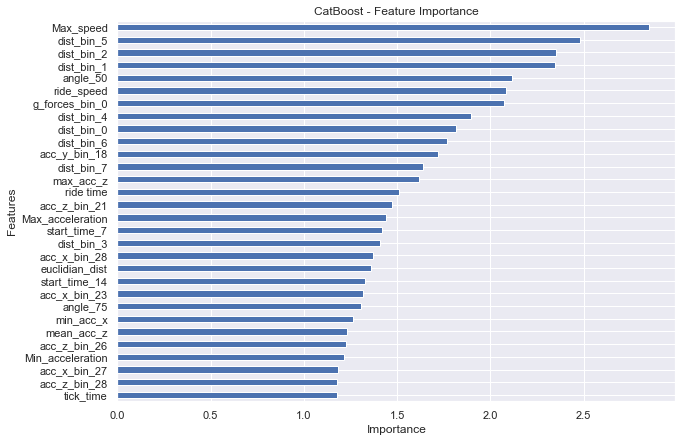

In [245]:
plot_features_catboost(model)

## Сохраним подтюненую модель в файл

In [246]:
#model.save_model('catboost_model_tuned.dump')

In [247]:
#model = CatBoostClassifier()
#model.load_model('catboost_model_tuned.dump');

## Функция для создания предсказаний из файла типа inc_points

In [248]:
def make_predictions(filename, model = model):
    print("Reading file...")
    inc_points = pd.read_csv(filename, parse_dates = ['PointDate'])
    print("File read completed\nCreating Features")
    feature_df = build_features(inc_points)
    print("Making predictions")
    preds = model.predict(feature_df)
    return (preds)

In [250]:
#preds = make_predictions('inc_points_2.csv')